In [1]:
###########################################################
# Imports
###########################################################
import sys
import os
sys.path.insert(0, os.getcwd())

import numpy as np
import matplotlib.pyplot as plt
import copy
import Padding
import math

In [2]:
#############################
# BOGUS values
#############################

BOGUS_INT = -999

In [3]:
#############################
# Define file
#############################

inputFile = sys.path[0] + '/files/networkScores.npz'
outputFile = sys.path[0] + '/files/newHierarchy.npz'

In [4]:
#############################
# Read file
#############################

print('Reading file: ', str(outputFile),', This may take a while...')

data = np.load(inputFile)

primary_link_mask_in = data['primary_link_mask_main']
primary_particleID_in = data['primary_particleID_main']
primary_trueGen_in = data['primary_trueGen_main']
primary_trueParentID_in = data['primary_trueParentID_main']
primary_trackScore_in = data['primary_trackScore_main']
primary_score_in = data['primary_score_main']
primary_upstreamVertexX_in = data['primary_upstreamVertexX_main']
primary_upstreamVertexY_in = data['primary_upstreamVertexY_main']
primary_upstreamVertexZ_in = data['primary_upstreamVertexZ_main']
primary_downstreamVertexX_in = data['primary_downstreamVertexX_main']
primary_downstreamVertexY_in = data['primary_downstreamVertexY_main']
primary_downstreamVertexZ_in = data['primary_downstreamVertexZ_main']

laterTier_link_mask_in = data['laterTier_link_mask_main']
laterTier_trueChildGen_in = data['laterTier_trueChildGen_main']
laterTier_parentID_in = data['laterTier_parentID_main']
laterTier_childID_in = data['laterTier_childID_main']
laterTier_nuVertexSep_in = data['laterTier_nuVertexSep_main']
laterTier_score_in = data['laterTier_score_main']
laterTier_parentNSpacepoints_in = data['laterTier_parentNSpacepoints_main']
laterTier_separation3D_in = data['laterTier_separation3D_main']
        
nEntries = len(primary_link_mask_in)

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy_PR/Hierarchy_GNN/files/newHierarchy.npz , This may take a while...


In [5]:
############################
# Get the child dict
############################   

PRIMARY_REGION = 15.0
    
parentToChildDict_main = []    
childToParentDict_main = []    
    
for iEvent in range(nEntries) :
    
    # Get data for the event
    primary_link_mask = np.array(primary_link_mask_in[iEvent])    
    primary_particleID = np.array(primary_particleID_in[iEvent])[primary_link_mask]
    nParticles = np.count_nonzero(primary_link_mask)
    
    laterTier_link_mask = np.array(laterTier_link_mask_in[iEvent])
    laterTier_childID = np.array(laterTier_childID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_parentID = np.array(laterTier_parentID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_nuVertexSep = np.array(laterTier_nuVertexSep_in[iEvent])[laterTier_link_mask]
    laterTier_score = np.array(laterTier_score_in[iEvent])[laterTier_link_mask]
    laterTier_parentNSpacepoints = np.array(laterTier_parentNSpacepoints_in[iEvent])[laterTier_link_mask]
    laterTier_separation3D = np.array(laterTier_separation3D_in[iEvent])[laterTier_link_mask]

    parentToChildDict = {}
    childToParentDict = {}

    for particleID in primary_particleID :
        parentToChildDict[particleID] = []
        childToParentDict[particleID] = []

    for index in range(nParticles) :
        
        this_particleID = primary_particleID[index]

        if this_particleID in laterTier_childID : 
            
            linkIndices = np.where(laterTier_childID == this_particleID)[0]
            
            foundParentID = -1
            highestNSpacepoints = -1.0
            lowestSeparation = 100000000000.0
            highestLinkScore = -1.0      

            for linkIndex in linkIndices :
                
                if (laterTier_nuVertexSep[linkIndex] < PRIMARY_REGION) :
                    continue 
                    
                # Has parent been considered as a primary? - ISOBEL WHY DOES THIS HAPPEN
                if (len(np.where(primary_particleID == laterTier_parentID[linkIndex])[0]) == 0) :
                    continue
                        
                # Need a tie-breaker!        
                #best = (laterTier_parentNSpacepoints[linkIndex] > highestNSpacepoints) if (math.isclose(laterTier_score[linkIndex], highestLinkScore)) else (laterTier_score[linkIndex] > highestLinkScore)
                best = (laterTier_separation3D[linkIndex] < lowestSeparation) if (math.isclose(laterTier_score[linkIndex], highestLinkScore)) else (laterTier_score[linkIndex] > highestLinkScore)                                                                              
        
                if (best) :
                    #highestNSpacepoints = laterTier_parentNSpacepoints[linkIndex]
                    lowestSeparation = laterTier_separation3D[linkIndex]
                    highestLinkScore = laterTier_score[linkIndex]
                    foundParentID = laterTier_parentID[linkIndex]                        

            if (foundParentID >= 0) :
                parentToChildDict[foundParentID].append(this_particleID)
                childToParentDict[this_particleID].append(foundParentID)
                
    parentToChildDict_main.append(parentToChildDict)
    childToParentDict_main.append(childToParentDict)

In [6]:
# print('parentToChildDict_main:', parentToChildDict_main)
# print('childToParentDict_main:', childToParentDict_main)

In [7]:
############################
# Tune primaries
############################

primary_thresholds = []

# [track, shower]
primary_efficiency = [[],[]]
primary_purity = [[], []]
primary_metric = [[], []]
primaries_as_primaries_frac = [[], []]
primaries_as_other_frac = [[], []]
other_as_primaries_frac = [[], []]
other_as_other_frac = [[], []]

############################
# Loop through thresholds
############################
for primary_threshold in range(0,20) :
    
    primary_threshold /= float(20)
    #print('---------------------------------------------')
    #print('primary_threshold:', primary_threshold)
    #print('')
    
    primary_thresholds.append(primary_threshold)
    
    n_true_primaries = [0, 0]
    n_primaries_as_primaries = [0, 0]
    n_primaries_as_other = [0, 0]
    n_primaries_as_nothing = [0, 0]
    n_true_other = [0, 0]
    n_other_as_primaries = [0, 0]
    n_other_as_other = [0, 0]
    n_other_as_nothing = [0, 0]
    
    ############################
    # Loop through events
    ############################
    for iEvent in range(nEntries) :

        # Get data for event
        primary_link_mask = np.array(primary_link_mask_in[iEvent])        
        trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
        trueVisibleGeneration = np.array(primary_trueGen_in[iEvent], dtype='int')[primary_link_mask]
        primaryScores = np.array(primary_score_in[iEvent])[primary_link_mask]                
        nParticles = np.count_nonzero(primary_link_mask)        
        
        for iParticle in range(nParticles) :
            
            trackShowerIndex = (0 if (trackShowerScore[iParticle] > 0.5) else 1)

            if (trueVisibleGeneration[iParticle] == 2) :
                n_true_primaries[trackShowerIndex] += 1
                
                if ((primaryScores[iParticle] > primary_threshold)) :
                    n_primaries_as_primaries[trackShowerIndex] += 1
                else :
                    n_primaries_as_other[trackShowerIndex] += 1
            else :
                n_true_other[trackShowerIndex] += 1
                
                if ((primaryScores[iParticle] > primary_threshold)) :
                    n_other_as_primaries[trackShowerIndex] += 1
                else :
                    n_other_as_other[trackShowerIndex] += 1
                                        
    ############################
    # Work out metrics
    ############################
    for i in [0, 1] :
        selected_primaries = n_primaries_as_primaries[i] + n_other_as_primaries[i]
        primary_efficiency[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i])/float(n_true_primaries[i]))
        primary_purity[i].append(0 if selected_primaries == 0 else float(n_primaries_as_primaries[i])/float(selected_primaries))
        primary_metric[i].append(primary_efficiency[i][-1] * primary_purity[i][-1])

        primaries_as_primaries_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i]) / float(n_true_primaries[i]))
        primaries_as_other_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_other[i]) / float(n_true_primaries[i]))
        other_as_primaries_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_primaries[i]) / float(n_true_other[i]))
        other_as_other_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_other[i]) / float(n_true_other[i]))
    
#print('---------------------------------------------')


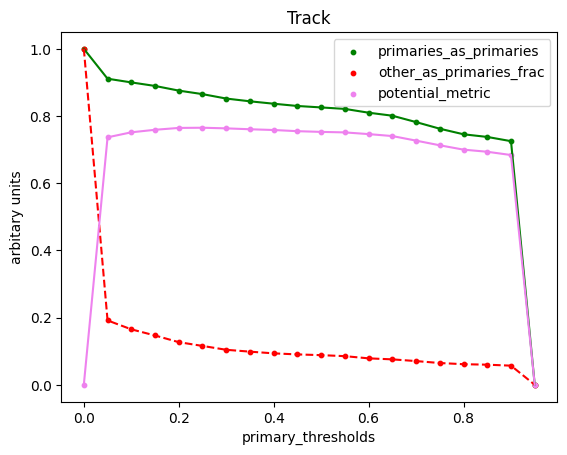

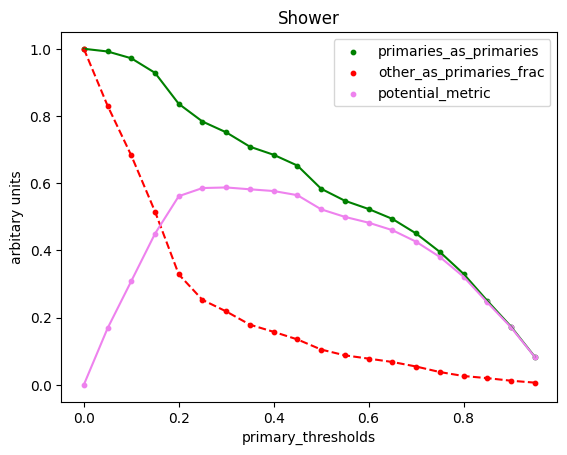

In [8]:
############################
# Draw primary plots!
############################

potential_metric = [np.array(primaries_as_primaries_frac[0]) * np.array(other_as_other_frac[0]), np.array(primaries_as_primaries_frac[1]) * np.array(other_as_other_frac[1])]


for i in [0, 1] :
#     plt.clf()
#     plt.scatter(primary_thresholds, primary_efficiency[i], color='red', label='efficiency', s=10)
#     plt.plot(primary_thresholds, primary_efficiency[i], color='red')
#     plt.scatter(primary_thresholds, primary_purity[i], color='green', label='purity', s=10)
#     plt.plot(primary_thresholds, primary_purity[i], color='green')
#     plt.scatter(primary_thresholds, primary_metric[i], color='violet', label='efficiency*purity', s=10)
#     plt.plot(primary_thresholds, primary_metric[i], color='violet')

#     plt.title('Track' if i == 0 else 'Shower')
#     plt.xlabel('primary_thresholds')
#     plt.ylabel('arbitary units')
#     plt.legend()
#     plt.show()

    ############################

    plt.clf()
    plt.scatter(primary_thresholds, primaries_as_primaries_frac[i], color='green', label='primaries_as_primaries', s=10)
    plt.plot(primary_thresholds, primaries_as_primaries_frac[i], color='green')
    #plt.scatter(primary_thresholds, primaries_as_other_frac[i], color='red', label='primaries_as_other_frac', s=10)
    #plt.plot(primary_thresholds, primaries_as_other_frac[i], color='red')
    #plt.scatter(primary_thresholds, other_as_other_frac[i], color='green', label='other_as_other_frac', s=10)
    #plt.plot(primary_thresholds, other_as_other_frac[i], color='green', linestyle='dashed')
    plt.scatter(primary_thresholds, other_as_primaries_frac[i], color='red', label='other_as_primaries_frac', s=10)
    plt.plot(primary_thresholds, other_as_primaries_frac[i], color='red', linestyle='dashed')


    plt.scatter(primary_thresholds, potential_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(primary_thresholds, potential_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('primary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [9]:
#######################################
# Define optimal primary threshold
#######################################

PRIMARY_THRESHOLD_TRACK = 0.80
PRIMARY_THRESHOLD_SHOWER = 0.45

In [10]:
##################################################
# Build the primary tier with optimised threshold!
##################################################

new_gen = []
new_parentID = []
primaries = []

for iEvent in range(nEntries) :

    # Get data for event
    primary_link_mask = np.array(primary_link_mask_in[iEvent])        
    trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
    primaryScores = np.array(primary_score_in[iEvent])[primary_link_mask]  
    primaryParticleID = np.array(primary_particleID_in[iEvent], dtype='int')[primary_link_mask]
    nParticles = np.count_nonzero(primary_link_mask)    
        
    this_parentID = [BOGUS_INT] * nParticles
    this_gen = [BOGUS_INT] * nParticles
    this_pfpOrientation = [BOGUS_INT] * nParticles
    
    this_primaries = []
    
    for iParticle in range(nParticles) :
        
        particleID = primaryParticleID[iParticle]
        isTrack = trackShowerScore[iParticle] > 0.5
            
        if ((isTrack and primaryScores[iParticle] > PRIMARY_THRESHOLD_TRACK) or
            ((not isTrack) and primaryScores[iParticle] > PRIMARY_THRESHOLD_SHOWER)) :
            this_primaries.append(particleID)
            this_gen[iParticle] = 2
            this_parentID[iParticle] = -1
    
    new_gen.append(this_gen)
    new_parentID.append(this_parentID)
    primaries.append(this_primaries)

In [11]:
print('new_gen:', new_gen[0])
print('new_parentID:', new_parentID[0])
print('primaries:', primaries[0])

new_gen: [2, 2, -999]
new_parentID: [-1, -1, -999]
primaries: [2, 0]


In [12]:
########################################
# Make copies to save...
########################################

new_gen_pass1 = copy.deepcopy(new_gen)
new_parentID_pass1 = copy.deepcopy(new_parentID)

In [13]:
############################
# Tune higher tiers
############################

############################
# first assign to best!!!
############################

higher_thresholds = []

# [track, shower]
secondary_correct_parent_frac = [[], []]
secondary_no_parent_frac = [[], []]
secondary_incorrect_parent_frac = [[], []]

tertiary_correct_parent_frac = [[], []]
tertiary_no_parent_frac = [[], []]
tertiary_incorrect_parent_frac = [[], []]

higher_correct_parent_frac = [[], []]
higher_no_parent_frac = [[], []]
higher_incorrect_parent_frac = [[], []]

############################
# Loop through thresholds
############################
for higher_threshold in range(0,20) :
    
    higher_threshold /= float(20)
    #print('---------------------------------------------')
    #print('higher_threshold:', higher_threshold)
    #print('')
    
    higher_thresholds.append(higher_threshold)

    n_secondary = [0, 0]
    secondary_correct_parent = [0, 0]
    secondary_no_parent = [0, 0]
    secondary_incorrect_parent = [0, 0]

    n_tertiary = [0, 0]
    tertiary_correct_parent = [0, 0]
    tertiary_no_parent = [0, 0]
    tertiary_incorrect_parent = [0, 0]
    
    n_higher = [0, 0]
    higher_correct_parent = [0, 0]
    higher_no_parent = [0, 0]
    higher_incorrect_parent = [0, 0]

    ############################
    # Loop through events
    ############################
    
    for iEvent in range(nEntries) :

        this_particle_tiers = [[]]
        this_particle_tiers[0] = primaries[iEvent]
        parentToChildDict = parentToChildDict_main[iEvent]

         # we have to make copies as we're going to want to fill these lists with the final result
        this_parentID = new_parentID[iEvent].copy()
        this_gen = new_gen[iEvent].copy()
        
        # Get data for the event
        primary_link_mask = np.array(primary_link_mask_in[iEvent])    
        primary_particleID = np.array(primary_particleID_in[iEvent])[primary_link_mask]
        trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
        trueVisibleGeneration = np.array(primary_trueGen_in[iEvent], dtype='int')[primary_link_mask]
        trueVisibleParentID = np.array(primary_trueParentID_in[iEvent], dtype='int')[primary_link_mask]
        nParticles = np.count_nonzero(primary_link_mask)

        laterTier_link_mask = np.array(laterTier_link_mask_in[iEvent])
        laterTier_childID = np.array(laterTier_childID_in[iEvent], dtype='int')[laterTier_link_mask]
        laterTier_parentID = np.array(laterTier_parentID_in[iEvent], dtype='int')[laterTier_link_mask]
        laterTier_nuVertexSep = np.array(laterTier_nuVertexSep_in[iEvent])[laterTier_link_mask]
        laterTier_score = np.array(laterTier_score_in[iEvent])[laterTier_link_mask]
        
        ############################
        # Build hierarchy
        ############################      
        # Fill each tier at a time
        while (len(this_particle_tiers[-1]) != 0) :
            
            tier = []
            
            # Add in highest?
            for parentID in this_particle_tiers[-1]:
                
                iParent = np.where(primary_particleID == parentID)[0][0]
                
                for childID in parentToChildDict[parentID] :
                    
                    iChild = np.where(primary_particleID == childID)[0][0]
                    
                    # If the child has already been assigned a parent
                    if (this_gen[iChild] != BOGUS_INT) :
                        continue
                        
                    linkIndex = np.where(np.logical_and(laterTier_childID == childID, laterTier_parentID == parentID))[0]
                        
                    if (len(linkIndex) == 0) :
                        print('THIS SHOULD NOT HAPPEN!')
                        continue
                        
                    linkIndex = linkIndex[0]           
                    
                    isTrack = trackShowerScore[iChild] > 0.5
                    
                    if (laterTier_score[linkIndex] < higher_threshold) : 
                        continue

#                     # Secondary
#                     if ((len(this_particle_tiers) == 1) and isTrack and (laterTier_score[linkIndex] < 0.8)) :
#                         continue

#                     if ((len(this_particle_tiers) == 1) and (not isTrack) and (laterTier_score[linkIndex] < 0.8)) :
#                         continue                     

#                     if ((len(this_particle_tiers) != 1) and (laterTier_score[linkIndex] < higher_threshold)) : 
#                         continue
                        
                    this_parentID[iChild] = parentID
                    this_gen[iChild] = len(this_particle_tiers) + 2
                    tier.append(childID)

            this_particle_tiers.append(tier)
            
        ############################
        # Turn into numpy arrays
        ############################  
        this_parentID = np.array(this_parentID)
        this_gen = np.array(this_gen)

        for trackShowerIndex in [0, 1] :
            trackShower_mask = (trackShowerScore > 0.5) if trackShowerIndex == 0 else np.logical_not(trackShowerScore > 0.5)

            #########################
            # Get tier masks
            #########################
            true_primary_mask = np.logical_and(trackShower_mask, trueVisibleGeneration == 2)
            true_secondary_mask = np.logical_and(trackShower_mask, trueVisibleGeneration == 3)
            true_tertiary_mask = np.logical_and(trackShower_mask, trueVisibleGeneration == 4)
            true_higher_mask = np.logical_and(trackShower_mask, np.logical_not(np.logical_or(true_primary_mask, np.logical_or(true_secondary_mask, true_tertiary_mask))))

            ############################
            # Counts
            ############################ 
            # Secondary
            n_secondary[trackShowerIndex] += np.count_nonzero(true_secondary_mask)
            secondary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentID[true_secondary_mask] == this_parentID[true_secondary_mask], 
                                                                                          this_gen[true_secondary_mask] == 3))
            secondary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_secondary_mask] == BOGUS_INT)            
            secondary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(trueVisibleParentID[true_secondary_mask] == this_parentID[true_secondary_mask], \
                                                                                                          np.logical_or(this_gen[true_secondary_mask] == 2, \
                                                                                                                        this_gen[true_secondary_mask] == BOGUS_INT))))
            # Tertiary
            n_tertiary[trackShowerIndex] += np.count_nonzero(true_tertiary_mask)
            tertiary_correct_parent[trackShowerIndex] += np.count_nonzero(np.logical_and(trueVisibleParentID[true_tertiary_mask] == this_parentID[true_tertiary_mask], 
                                                                                         this_gen[true_tertiary_mask] == 4))
            tertiary_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_tertiary_mask] == BOGUS_INT)
            tertiary_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(trueVisibleParentID[true_tertiary_mask] == this_parentID[true_tertiary_mask], \
                                                                                                         np.logical_or(this_gen[true_tertiary_mask] == 2, \
                                                                                                                       this_gen[true_tertiary_mask] == BOGUS_INT))))

            n_higher[trackShowerIndex] += np.count_nonzero(true_higher_mask)
            higher_correct_parent[trackShowerIndex] += np.count_nonzero(trueVisibleParentID[true_higher_mask] == this_parentID[true_higher_mask])
            higher_no_parent[trackShowerIndex] += np.count_nonzero(this_gen[true_higher_mask] == BOGUS_INT)
            higher_incorrect_parent[trackShowerIndex] += np.count_nonzero(np.logical_not(np.logical_or(trueVisibleParentID[true_higher_mask] == this_parentID[true_higher_mask], \
                                                                                                       np.logical_or(this_gen[true_higher_mask] == 2, \
                                                                                                                     this_gen[true_higher_mask] == BOGUS_INT))))
    #####################################
    # Calculate metrics for threshold
    #####################################    
    for trackShowerIndex in [0, 1] :
        
        secondary_correct_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_correct_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_no_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_no_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))
        secondary_incorrect_parent_frac[trackShowerIndex].append(0 if n_secondary[trackShowerIndex] == 0 else float(secondary_incorrect_parent[trackShowerIndex])/float(n_secondary[trackShowerIndex]))

        tertiary_correct_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_correct_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_no_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_no_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))
        tertiary_incorrect_parent_frac[trackShowerIndex].append(0 if n_tertiary[trackShowerIndex] == 0 else float(tertiary_incorrect_parent[trackShowerIndex])/float(n_tertiary[trackShowerIndex]))

        higher_correct_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_correct_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_no_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_no_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))
        higher_incorrect_parent_frac[trackShowerIndex].append(0 if n_higher[trackShowerIndex] == 0 else float(higher_incorrect_parent[trackShowerIndex])/float(n_higher[trackShowerIndex]))

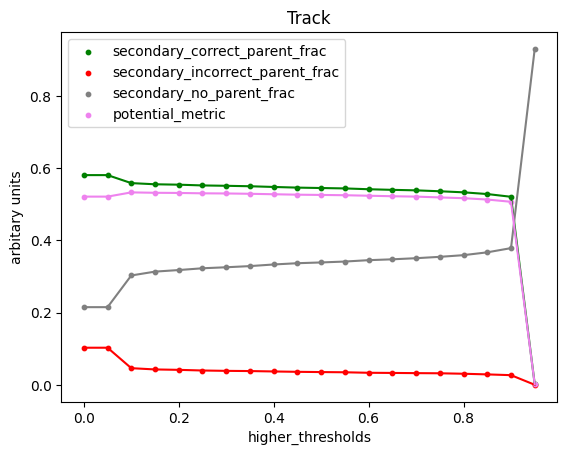

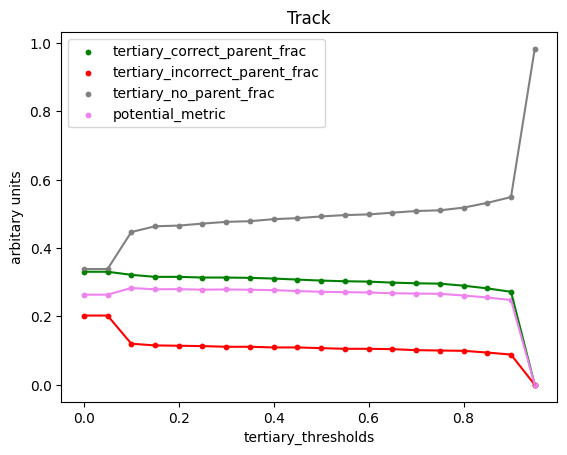

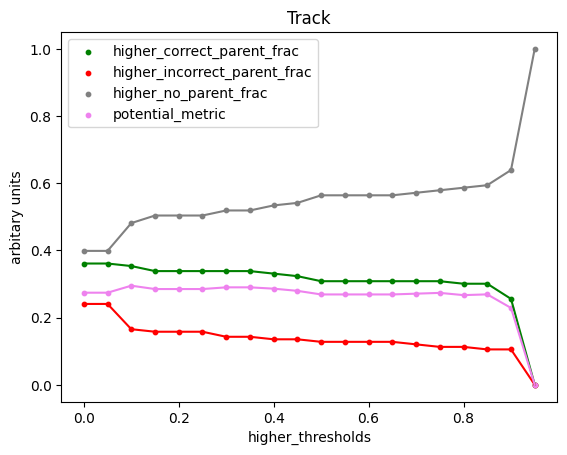

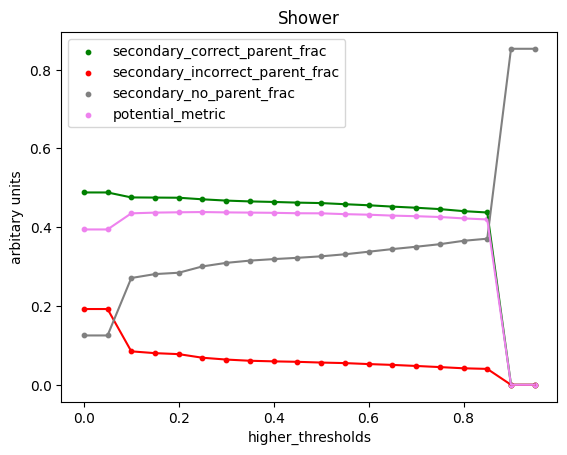

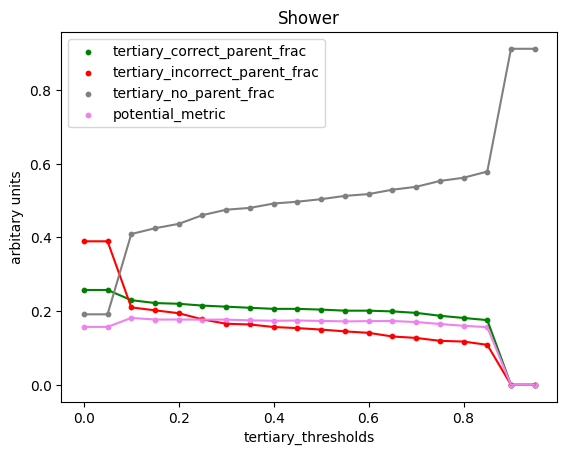

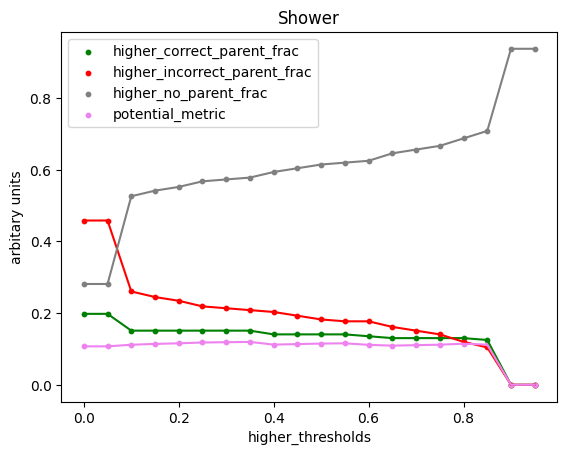

In [14]:
############################
# Draw later tier plots!
############################

potential_secondary_metric = [np.array(secondary_correct_parent_frac[0]) * (1 - np.array(secondary_incorrect_parent_frac[0])), np.array(secondary_correct_parent_frac[1]) * (1 - np.array(secondary_incorrect_parent_frac[1]))]
potential_tertiary_metric = [np.array(tertiary_correct_parent_frac[0]) * (1 - np.array(tertiary_incorrect_parent_frac[0])), np.array(tertiary_correct_parent_frac[1]) * (1 - np.array(tertiary_incorrect_parent_frac[1]))]
potential_higher_metric = [np.array(higher_correct_parent_frac[0]) * (1 - np.array(higher_incorrect_parent_frac[0])), np.array(higher_correct_parent_frac[1]) * (1 - np.array(higher_incorrect_parent_frac[1]))]

############################
# Higher tier plots!
############################
for i in [0, 1] :
    plt.clf()
    plt.scatter(higher_thresholds, secondary_correct_parent_frac[i], color='green', label='secondary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, secondary_incorrect_parent_frac[i], color='red', label='secondary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, secondary_no_parent_frac[i], color='gray', label='secondary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, secondary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_secondary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_secondary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, tertiary_correct_parent_frac[i], color='green', label='tertiary_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red', label='tertiary_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, tertiary_no_parent_frac[i], color='gray', label='tertiary_no_parent_frac', s=10)
    plt.plot(higher_thresholds, tertiary_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_tertiary_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_tertiary_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('tertiary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

    ############################

    plt.clf()
    plt.scatter(higher_thresholds, higher_correct_parent_frac[i], color='green', label='higher_correct_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_correct_parent_frac[i], color='green')

    plt.scatter(higher_thresholds, higher_incorrect_parent_frac[i], color='red', label='higher_incorrect_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_incorrect_parent_frac[i], color='red')

    plt.scatter(higher_thresholds, higher_no_parent_frac[i], color='gray', label='higher_no_parent_frac', s=10)
    plt.plot(higher_thresholds, higher_no_parent_frac[i], color='gray')

    plt.scatter(higher_thresholds, potential_higher_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(higher_thresholds, potential_higher_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('higher_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [15]:
#######################################
# Define optimal higher threshold
#######################################

SECONDARY_THRESHOLD_TRACK_PASS1 = 0.80
SECONDARY_THRESHOLD_SHOWER_PASS1 = 0.80

HIGHER_THRESHOLD_TRACK_PASS1 = 0.80
HIGHER_THRESHOLD_SHOWER_PASS1 = 0.80

In [16]:
##################################################
# Build the higher tier with optimised threshold!
##################################################

for iEvent in range(nEntries) :

    this_particle_tiers = [[]]
    this_particle_tiers[0] = primaries[iEvent]
    parentToChildDict = parentToChildDict_main[iEvent]    

    # In this case we do not want to make a copy
    this_parentID = new_parentID[iEvent] 
    this_gen = new_gen[iEvent] 

    # Get data for the event
    primary_link_mask = np.array(primary_link_mask_in[iEvent])    
    primary_particleID = np.array(primary_particleID_in[iEvent])[primary_link_mask]
    trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
    trueVisibleGeneration = np.array(primary_trueGen_in[iEvent], dtype='int')[primary_link_mask]
    trueVisibleParentID = np.array(primary_trueParentID_in[iEvent], dtype='int')[primary_link_mask]
    nParticles = np.count_nonzero(primary_link_mask)

    laterTier_link_mask = np.array(laterTier_link_mask_in[iEvent])
    laterTier_childID = np.array(laterTier_childID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_parentID = np.array(laterTier_parentID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_nuVertexSep = np.array(laterTier_nuVertexSep_in[iEvent])[laterTier_link_mask]
    laterTier_score = np.array(laterTier_score_in[iEvent])[laterTier_link_mask]    
     
    ############################
    # Build hierarchy
    ############################    
    # Fill each tier at a time
    while (len(this_particle_tiers[-1]) != 0) :

        tier = []

        # Add in highest?
        for parentID in this_particle_tiers[-1]:

            iParent = np.where(primary_particleID == parentID)[0][0]

            for childID in parentToChildDict[parentID] :

                iChild = np.where(primary_particleID == childID)[0][0]    
    
                # If the child has already been assigned a parent
                if (this_gen[iChild] != BOGUS_INT) :
                    continue
                        
                linkIndex = np.where(np.logical_and(laterTier_childID == childID, laterTier_parentID == parentID))[0]

                if (len(linkIndex) == 0) :
                    print('THIS SHOULD NOT HAPPEN!')
                    continue
                        
                linkIndex = linkIndex[0]           

                isTrack = trackShowerScore[iChild] > 0.5

                # Secondary
                if ((len(this_particle_tiers) == 1) and isTrack and (laterTier_score[linkIndex] < SECONDARY_THRESHOLD_TRACK_PASS1)) :
                    continue

                if ((len(this_particle_tiers) == 1) and (not isTrack) and (laterTier_score[linkIndex] < SECONDARY_THRESHOLD_SHOWER_PASS1)) :
                    continue                     

                # Higher
                if ((len(this_particle_tiers) != 1) and (isTrack) and (laterTier_score[linkIndex] < HIGHER_THRESHOLD_TRACK_PASS1)) : 
                    continue

                if ((len(this_particle_tiers) != 1) and (not isTrack) and (laterTier_score[linkIndex] < HIGHER_THRESHOLD_SHOWER_PASS1)) : 
                    continue

                this_parentID[iChild] = parentID
                this_gen[iChild] = len(this_particle_tiers) + 2
                tier.append(childID)

        this_particle_tiers.append(tier)                    

In [17]:
########################################
# Make copies to save...
########################################
new_gen_pass2 = copy.deepcopy(new_gen)
new_parentID_pass2 = copy.deepcopy(new_parentID)

In [18]:
################################################
# See if I can add more to the primaries?
################################################

primary_thresholds = []

# [track, shower]
primary_efficiency = [[],[]]
primary_purity = [[], []]
primary_metric = [[], []]
primaries_as_primaries_frac = [[], []]
primaries_as_other_frac = [[], []]
other_as_primaries_frac = [[], []]
other_as_other_frac = [[], []]

############################
# Loop through thresholds
############################
for primary_threshold in range(0,20) :
    
    primary_threshold /= float(20)
    #print('---------------------------------------------')
    #print('primary_threshold:', primary_threshold)
    #print('')
    
    primary_thresholds.append(primary_threshold)
    
    n_true_primaries = [0, 0]
    n_primaries_as_primaries = [0, 0]
    n_primaries_as_other = [0, 0]
    n_primaries_as_nothing = [0, 0]
    n_true_other = [0, 0]
    n_other_as_primaries = [0, 0]
    n_other_as_other = [0, 0]
    n_other_as_nothing = [0, 0]
    
    ############################
    # Loop through events
    ############################
    for iEvent in range(nEntries) :
        
        # we have to make copies as we're going to want to fill these lists with the final result
        this_gen = new_gen[iEvent].copy()
        childToParentDict = childToParentDict_main[iEvent]
        
        # Get data for the event
        primary_link_mask = np.array(primary_link_mask_in[iEvent])    
        primary_particleID = np.array(primary_particleID_in[iEvent])[primary_link_mask]
        trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
        trueVisibleGeneration = np.array(primary_trueGen_in[iEvent], dtype='int')[primary_link_mask]
        nParticles = np.count_nonzero(primary_link_mask)

        laterTier_link_mask = np.array(laterTier_link_mask_in[iEvent])
        laterTier_childID = np.array(laterTier_childID_in[iEvent], dtype='int')[laterTier_link_mask]
        laterTier_parentID = np.array(laterTier_parentID_in[iEvent], dtype='int')[laterTier_link_mask]
        laterTier_score = np.array(laterTier_score_in[iEvent])[laterTier_link_mask]            
        
        for iParticle in range(nParticles) :
            
            particleID = primary_particleID[iParticle]
            trackShowerIndex = (0 if (trackShowerScore[iParticle] > 0.5) else 1)

            if (trueVisibleGeneration[iParticle] == 2) :
                n_true_primaries[trackShowerIndex] += 1
                
                if (this_gen[iParticle] != BOGUS_INT) :
                    continue
                else :
                    if (len(childToParentDict[particleID]) == 0) :
                        n_primaries_as_primaries[trackShowerIndex] += 1
                        continue     
                        
                    linkIndex = np.where(np.logical_and(laterTier_childID == particleID, laterTier_parentID == childToParentDict[particleID][0]))[0][0]

                    if (laterTier_score[linkIndex] < primary_threshold) :
                        n_primaries_as_primaries[trackShowerIndex] += 1
                    else :
                        n_primaries_as_other[trackShowerIndex] += 1
            else :
                n_true_other[trackShowerIndex] += 1
                
                if (this_gen[iParticle] != BOGUS_INT) :
                    continue
                else :
                    if (len(childToParentDict[particleID]) == 0) :
                        n_other_as_primaries[trackShowerIndex] += 1
                        continue     
                        
                    linkIndex = np.where(np.logical_and(laterTier_childID == particleID, laterTier_parentID == childToParentDict[particleID][0]))[0][0]

                    if (laterTier_score[linkIndex] < primary_threshold) :
                        n_other_as_primaries[trackShowerIndex] += 1
                    else :
                        n_other_as_other[trackShowerIndex] += 1
                                        
    ############################
    # Work out metrics
    ############################
    for i in [0, 1] :
        selected_primaries = n_primaries_as_primaries[i] + n_other_as_primaries[i]
        primary_efficiency[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i])/float(n_true_primaries[i]))
        primary_purity[i].append(0 if selected_primaries == 0 else float(n_primaries_as_primaries[i])/float(selected_primaries))
        primary_metric[i].append(primary_efficiency[i][-1] * primary_purity[i][-1])

        primaries_as_primaries_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_primaries[i]) / float(n_true_primaries[i]))
        primaries_as_other_frac[i].append(0 if n_true_primaries[i] == 0 else float(n_primaries_as_other[i]) / float(n_true_primaries[i]))
        other_as_primaries_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_primaries[i]) / float(n_true_other[i]))
        other_as_other_frac[i].append(0 if n_true_other[i] == 0 else float(n_other_as_other[i]) / float(n_true_other[i]))

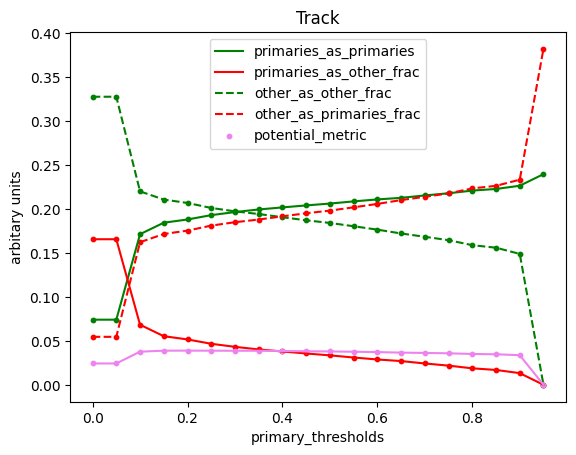

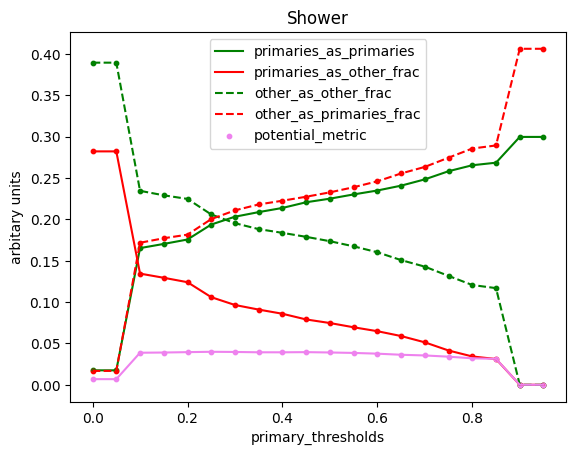

In [19]:
############################
# Draw primary plots!
############################

potential_metric = [np.array(primaries_as_primaries_frac[0]) * np.array(other_as_other_frac[0]), np.array(primaries_as_primaries_frac[1]) * np.array(other_as_other_frac[1])]


for i in [0, 1] :
#     plt.clf()
#     plt.scatter(primary_thresholds, primary_efficiency[i], color='red', label='efficiency', s=10)
#     plt.plot(primary_thresholds, primary_efficiency[i], color='red')
#     plt.scatter(primary_thresholds, primary_purity[i], color='green', label='purity', s=10)
#     plt.plot(primary_thresholds, primary_purity[i], color='green')
#     plt.scatter(primary_thresholds, primary_metric[i], color='violet', label='efficiency*purity', s=10)
#     plt.plot(primary_thresholds, primary_metric[i], color='violet')

#     plt.title('Track' if i == 0 else 'Shower')
#     plt.xlabel('primary_thresholds')
#     plt.ylabel('arbitary units')
#     plt.legend()
#     plt.show()

    ############################

    plt.clf()
    plt.scatter(primary_thresholds, primaries_as_primaries_frac[i], color='green', s=10)
    plt.plot(primary_thresholds, primaries_as_primaries_frac[i], color='green', label='primaries_as_primaries')
    plt.scatter(primary_thresholds, primaries_as_other_frac[i], color='red', s=10)
    plt.plot(primary_thresholds, primaries_as_other_frac[i], color='red', label='primaries_as_other_frac')
    plt.scatter(primary_thresholds, other_as_other_frac[i], color='green', s=10)
    plt.plot(primary_thresholds, other_as_other_frac[i], color='green', linestyle='dashed', label='other_as_other_frac')
    plt.scatter(primary_thresholds, other_as_primaries_frac[i], color='red', s=10)
    plt.plot(primary_thresholds, other_as_primaries_frac[i], color='red', linestyle='dashed', label='other_as_primaries_frac')


    plt.scatter(primary_thresholds, potential_metric[i], color='violet', label='potential_metric', s=10)
    plt.plot(primary_thresholds, potential_metric[i], color='violet')

    plt.title('Track' if i == 0 else 'Shower')
    plt.xlabel('primary_thresholds')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()

In [20]:
PRIMARY_THRESHOLD_TRACK_PASS2 = 0.90
PRIMARY_THRESHOLD_SHOWER_PASS2 = 0.90

In [21]:
##################################################
# Build the primary tier with optimised threshold!
##################################################

for iEvent in range(nEntries) :
    
    childToParentDict = childToParentDict_main[iEvent]
    
    # We want to change these!
    this_parentID = new_parentID[iEvent]
    this_gen = new_gen[iEvent]
    this_primaries = primaries[iEvent]

    # Get data for the event
    primary_link_mask = np.array(primary_link_mask_in[iEvent])    
    primary_particleID = np.array(primary_particleID_in[iEvent])[primary_link_mask]
    trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
    trueVisibleGeneration = np.array(primary_trueGen_in[iEvent], dtype='int')[primary_link_mask]
    nParticles = np.count_nonzero(primary_link_mask)

    laterTier_link_mask = np.array(laterTier_link_mask_in[iEvent])
    laterTier_childID = np.array(laterTier_childID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_parentID = np.array(laterTier_parentID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_score = np.array(laterTier_score_in[iEvent])[laterTier_link_mask]      
    
    for iParticle in range(nParticles) :
        
        # If it has already been set?
        if (this_gen[iParticle] != BOGUS_INT) :
            continue
        
        particleID = primary_particleID[iParticle]
        isTrack = trackShowerScore[iParticle] > 0.5
        
        # Get later tier score
        laterTierScore = 0.0
        
        if (len(childToParentDict[particleID]) != 0) :
            laterTierLinkIndex = np.where(np.logical_and(laterTier_childID == particleID, laterTier_parentID == childToParentDict[particleID][0]))[0]
            laterTierScore = 0.0 if len(laterTierLinkIndex) == 0 else laterTier_score[laterTierLinkIndex[0]]
            
        if ((isTrack and (laterTierScore < PRIMARY_THRESHOLD_TRACK_PASS2)) or
            ((not isTrack) and (laterTierScore < PRIMARY_THRESHOLD_SHOWER_PASS2))) :
            this_primaries.append(particleID)
            this_gen[iParticle] = 2
            this_parentID[iParticle] = -1

In [22]:
########################################
# Make copies to save...
########################################

new_gen_pass3 = copy.deepcopy(new_gen)
new_parentID_pass3 = copy.deepcopy(new_parentID)

In [23]:
##################################################
# Try to assign any remaining in a smart way?
##################################################

for iEvent in range(nEntries) :
    
    # Create our particle hierarchy to build
    this_particle_tiers = [[]]
    this_particle_tiers[0] = primaries[iEvent]

    # In this case we do not want to make a copy
    this_parentID = new_parentID[iEvent] 
    this_gen = new_gen[iEvent] 
    childToParentDict = childToParentDict_main[iEvent]
    
    # Get data for the event
    primary_link_mask = np.array(primary_link_mask_in[iEvent])    
    primary_particleID = np.array(primary_particleID_in[iEvent])[primary_link_mask]
    trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
    trueVisibleGeneration = np.array(primary_trueGen_in[iEvent], dtype='int')[primary_link_mask]
    nParticles = np.count_nonzero(primary_link_mask)

    laterTier_link_mask = np.array(laterTier_link_mask_in[iEvent])
    laterTier_childID = np.array(laterTier_childID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_parentID = np.array(laterTier_parentID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_score = np.array(laterTier_score_in[iEvent])[laterTier_link_mask]   

    ############################
    # Build hierarchy
    ############################    
    while (len(this_particle_tiers[-1]) != 0) :

        tier = []

        # Loop over our children to see if we can assign them...
        for iParticle in range(nParticles) : 
            
            particleID = primary_particleID[iParticle]

            # If the child has already been assigned a parent
            if (this_gen[iParticle] != BOGUS_INT) :
                if (len(np.where(this_particle_tiers[-1] == this_parentID[iParticle])[0]) != 0) :
                    tier.append(particleID)
            else :
                if (len(childToParentDict[particleID]) != 0) :    
                    
                    parentID = childToParentDict[particleID][0]                    
                    
                    if (len(np.where(this_particle_tiers[-1] == parentID)[0]) != 0) :
                        this_parentID[iParticle] = parentID
                        this_gen[iParticle] = len(this_particle_tiers) + 2
                        tier.append(particleID)

        # Tier complete, add into hierarchy
        this_particle_tiers.append(tier)

In [24]:
########################################
# Make copies to save...
########################################

new_gen_pass4 = copy.deepcopy(new_gen)
new_parentID_pass4 = copy.deepcopy(new_parentID)

In [25]:
######################################
# Say that any remaining are primaries
###################################### 

for iEvent in range(nEntries) : 

    this_parentID = new_parentID[iEvent] # Will not make a copy (will be by reference)
    this_gen = new_gen[iEvent] # Will not make a copy (will be by reference)
    
    for iParticle in range(len(this_gen)) :
            
        if (this_gen[iParticle] == BOGUS_INT) :
            this_parentID[iParticle] = -1
            this_gen[iParticle] = 2


In [26]:
########################################
# Make copies to save...
########################################

new_gen_pass5 = copy.deepcopy(new_gen)
new_parentID_pass5 = copy.deepcopy(new_parentID)

In [27]:
########################################
# Try to do a little refinement 
########################################

for iEvent in range(nEntries) : 

    this_parentID = new_parentID[iEvent]
    this_gen = new_gen[iEvent]
    
    # Get data for the event
    primary_link_mask = np.array(primary_link_mask_in[iEvent])    
    primary_particleID = np.array(primary_particleID_in[iEvent])[primary_link_mask]
    trackShowerScore = np.array(primary_trackScore_in[iEvent])[primary_link_mask]
    trueVisibleGeneration = np.array(primary_trueGen_in[iEvent], dtype='int')[primary_link_mask]
    upstreamVertexX = np.array(primary_upstreamVertexX_in[iEvent])[primary_link_mask]
    upstreamVertexY = np.array(primary_upstreamVertexY_in[iEvent])[primary_link_mask]
    upstreamVertexZ = np.array(primary_upstreamVertexZ_in[iEvent])[primary_link_mask]
    downstreamVertexX = np.array(primary_downstreamVertexX_in[iEvent])[primary_link_mask]
    downstreamVertexY = np.array(primary_downstreamVertexY_in[iEvent])[primary_link_mask]
    downstreamVertexZ = np.array(primary_downstreamVertexZ_in[iEvent])[primary_link_mask]    
    nParticles = np.count_nonzero(primary_link_mask)    

    laterTier_link_mask = np.array(laterTier_link_mask_in[iEvent])
    laterTier_childID = np.array(laterTier_childID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_parentID = np.array(laterTier_parentID_in[iEvent], dtype='int')[laterTier_link_mask]
    laterTier_score = np.array(laterTier_score_in[iEvent])[laterTier_link_mask]          
    
    if (np.count_nonzero(np.array(this_gen)[trackShowerScore > 0.5] == 3) < 2) :
        continue
        
    jam = True
    count = 0
    
    while (jam) :
        
        jam = False
        minValue = 9000000
        bestParentID = -1
        iBestChild = -1
        
        # To stop infinite loops
        if count == 11 :
            break;
        
        for iChild in range(nParticles) :

            if (this_gen[iChild] != 3) :
                continue

            if (trackShowerScore[iChild] < 0.5) :
                continue
                
            childID = primary_particleID[iChild]
            currentChildParentID = this_parentID[iChild]
            iCurrentParent = np.where(primary_particleID == currentChildParentID)[0][0]

            for iParent in range(nParticles) :
                
                parentID = primary_particleID[iParent]
                currentParentParentID = this_parentID[iParent]
                
                if (currentChildParentID != currentParentParentID) :
                    continue

                if (iChild == iParent) :
                    continue
                
                if (this_gen[iParent] != 3) :
                    continue

                if (trackShowerScore[iParent] < 0.5) :
                    continue                          
                    
                linkIndices = np.where(np.logical_and(laterTier_childID == childID, laterTier_parentID == parentID))[0] 
                
                if (linkIndices.shape[0] == 0) :
                    continue

                if (laterTier_score[linkIndices[0]] < 0.9) :
                    continue
                    
                # positions for child
                child_upstreamVertex = np.array([upstreamVertexX[iChild], upstreamVertexY[iChild], upstreamVertexZ[iChild]])
                child_downstreamVertex = np.array([downstreamVertexX[iChild], downstreamVertexY[iChild], downstreamVertexZ[iChild]])
                # positions for parent
                parent_upstreamVertex = np.array([upstreamVertexX[iParent], upstreamVertexY[iParent], upstreamVertexZ[iParent]])
                parent_downstreamVertex = np.array([downstreamVertexX[iParent], downstreamVertexY[iParent], downstreamVertexZ[iParent]])
                # positions for current parent
                currentParent_upstreamVertex = np.array([upstreamVertexX[iCurrentParent], upstreamVertexY[iCurrentParent], upstreamVertexZ[iCurrentParent]])
                currentParent_downstreamVertex = np.array([downstreamVertexX[iCurrentParent], downstreamVertexY[iCurrentParent], downstreamVertexZ[iCurrentParent]])

                # Find child and parent POI
                childPOI = child_upstreamVertex
                parentPOI = currentParent_downstreamVertex
                minSep = 9000000000
                maxSep = -900000000
                
                for childVertex in [child_upstreamVertex, child_downstreamVertex] :
                    for currentParentVertex in [currentParent_upstreamVertex, currentParent_downstreamVertex] :
                        thisSep = np.linalg.norm(currentParentVertex - childVertex)
                        if (thisSep < minSep) :
                            minSep = thisSep
                            childPOI = childVertex
                            
                for parentVertex in [parent_upstreamVertex, parent_downstreamVertex] :
                    for currentParentVertex in [currentParent_upstreamVertex, currentParent_downstreamVertex] :
                        thisSep = np.linalg.norm(currentParentVertex - parentVertex)
                        if (thisSep > maxSep) :
                            maxSep = thisSep
                            parentPOI = parentVertex                            

                sepPOI = np.linalg.norm(parentPOI - childPOI)
                
                if ((sepPOI < 3.0) and (sepPOI < minValue)) :
                    minValue = sepPOI
                    bestParentID = parentID
                    iBestChild = iChild
                    jam = True
                    
        if (jam) :
            this_parentID[iBestChild] = bestParentID
            this_gen[iBestChild] = 4

In [28]:
########################################
# Make copies to save...
########################################

new_gen_pass6 = copy.deepcopy(new_gen)
new_parentID_pass6 = copy.deepcopy(new_parentID)

In [30]:
########################################
# Pandora hierarchy metrics
########################################

#Metrics.calculateMetrics_pandora(nEntries, particleMask_in, nSpacepoints_in, trackShowerScore_in, trueVisibleGeneration_in, trueVisibleParentSelf_in, pandoraParentSelf_in, pandoraGeneration_in)

NameError: name 'particleMask_in' is not defined

In [ ]:
print(print(primary_link_mask_in))

In [29]:
########################################
# Need to pad them so can save them
########################################

# Get target length to match input padded vectors
target_particle_length = primary_link_mask_in.shape[1]

# Pad 
new_gen_pass1 = Padding.process_array(new_gen_pass1, target_particle_length)
new_parentID_pass1 = Padding.process_array(new_parentID_pass1, target_particle_length)

new_gen_pass2 = Padding.process_array(new_gen_pass2, target_particle_length)
new_parentID_pass2 = Padding.process_array(new_parentID_pass2, target_particle_length)

new_gen_pass3 = Padding.process_array(new_gen_pass3, target_particle_length)
new_parentID_pass3 = Padding.process_array(new_parentID_pass3, target_particle_length)

new_gen_pass4 = Padding.process_array(new_gen_pass4, target_particle_length)
new_parentID_pass4 = Padding.process_array(new_parentID_pass4, target_particle_length)

new_gen_pass5 = Padding.process_array(new_gen_pass5, target_particle_length)
new_parentID_pass5 = Padding.process_array(new_parentID_pass5, target_particle_length)

new_gen_pass6 = Padding.process_array(new_gen_pass6, target_particle_length)
new_parentID_pass6 = Padding.process_array(new_parentID_pass6, target_particle_length)


In [30]:
########################################
# Save
########################################
    
np.savez(outputFile, \
         primary_link_mask = primary_link_mask_in, \
         #primary_particleID = primary_particleID_in, \
         #pfpTruePDG = primary_link_mask, \
         trueVisibleGeneration = primary_trueGen_in, \
         trueVisibleParentID = primary_trueParentID_in, \
         trackShowerScore = primary_trackScore_in, \
         new_gen_pass1 = new_gen_pass1, \
         new_parentID_pass1 = new_parentID_pass1, \
         new_gen_pass2 = new_gen_pass2, \
         new_parentID_pass2 = new_parentID_pass2, \
         new_gen_pass3 = new_gen_pass3, \
         new_parentID_pass3 = new_parentID_pass3, \
         new_gen_pass4 = new_gen_pass4, \
         new_parentID_pass4 = new_parentID_pass4, \
         new_gen_pass5 = new_gen_pass5, \
         new_parentID_pass5 = new_parentID_pass5, \
         new_gen_pass6 = new_gen_pass6, \
         new_parentID_pass6 = new_parentID_pass6)

